# Least Action

Load modules

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
import numpy as np
import scipy.optimize 
import pandas as pd
global g  
g=9.8

<div style="float: right;" markdown="1">
    <img src="figures/leastaction.png">
</div>
## Geometry interpretation
Following the geometry theory developed [here](http://www.eftaylor.com/software/ActionApplets/LeastAction.html), we will try to define something called the _Action_ for one small segment of the free fall movement in one-dimension. 

For that we need the experimental data consisting of the height of an object of mass $m$ in free fall, $x_i$, for each time $t_i$. This data would be fitted by polynomial of degree two, as displayed in the figure for one of the fitted segments of the plot of $x$ as a function of $t$. We take the origin of the coordinates at ground level. For each segment we can calculate an average kinetic energy, $T$, and an averge potential energy, $V$, in the limit of $\Delta t=t_2-t_1$ small. From the figure

\begin{align}
T_{12}=\frac12 m v^2\approx &\frac12 m\left(\frac{x_2-x_1}{t_2-t_1}\right)^2\,,&
V_{12}=-mgh\approx& -m g \frac{x_2+x_1}{2}\,.
\end{align}

We can then reformulate the problem of the free fall in the following terms. From all the possible curves that can interpolate the points $(t_1,x_1)$ and $(t_2,x_2)$, which is the correct one?. 

The answer obtained by Euler can be obtained from the definition of the function "Lagrangian"
$$L(t)=T(t)-V(t)$$

We define the "Action" of one interpolating function between the points $(t_1,x_1)$ and $(t_2,x_2)$ as
$$S=\int_{t_1}^{t_2} L\, {\rm d}t $$

The result if that correct interpolation is the one that has a minumum value for the Action!

For one segment of the action between $(t_1,x_1)$, and $(t_2,x_2)$, with $\Delta t$ sufficiently small such that $L$ can be considered constant, we have
\begin{eqnarray}
S_1&=&\int_{t_1}^{t_2} L dt \\
&\approx& \left[\frac12 m v^2-m g h \right]\Delta t\\
&\approx& \left[\frac12 m\left(\frac{x_2-x_1}{t_2-t_1}\right)^2-m g \frac{x_2+x_1}{2} \right](t_2-t_1)
\end{eqnarray}
that corresponds to Eq. (11) of Am. J. Phys, Vol. 72(2004)478: http://www.eftaylor.com/pub/Symmetries&ConsLaws.pdf

## Code implementation

### The Action
We define the Action $S$ such of an object of mass $m$ throw vertically upward from $x_{\hbox{ini}}$, such that $t_{\hbox{end}}$ seconds later the object return to a height $x_{\hbox{end}}$, as
\begin{eqnarray}
S&=&\int_{t_{\hbox{ini}}}^{t_{\hbox{end}}} L\, {\rm d}t \\
&=&\sum_i S_i \Delta t
\end{eqnarray}

In [3]:
def S(x,tend=3.,m=0.2,xini=0.,xend=0.):
    """
    Calculate the Action of an object of of mass 'm' throw vertically upward from 
       'xini', such that 'tend' seconds later the object return to a height 'xend'.
       Delta t must be constant.
       
    The defaults units for S are J.s   
    """
    t=float(tend)
    Dt=t/x[:-1].size
    x=np.asarray(x)
    #Fix initial and final point
    x[0]=xini
    x[-1]=xend
    return ((0.5*m*(x[1:]-x[:-1])**2/Dt**2-0.5*m*g*(x[1:]+x[:-1]))*Dt).sum()

### Example

For the default values build an intermediate set of points with $\Delta t=0.5$ s.

In [15]:
df=pd.DataFrame({'t':[0.,0.5,1.,1.5,2.,2.5,3.],'x':[0.,10,15.,22.,18.,5.,0.]})

#### Linear fit 

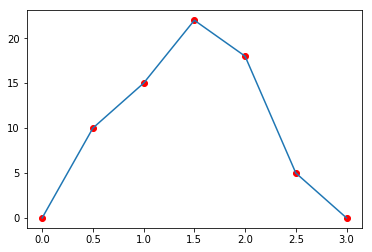

In [17]:
plt.plot(df.t,df.x,'ro')
plt.plot(df.t,df.x)

In [20]:
S(df.x.values)

8.1999999999999957

####  Polynomial fit 

In [44]:
coeffs=np.polyfit(df.t.values,df.x.values,6)
P=np.poly1d(coeffs)
print(P)

        6         5         4         3         2
-3.111 x + 32.67 x - 126.1 x + 218.5 x - 172.3 x + 65.33 x - 1.375e-12


In [45]:
P(df.x)

array([ -1.37502674e-12,  -9.03630000e+05,  -1.63159700e+07,
        -2.11683142e+08,  -5.61089100e+07,  -2.01500000e+03,
        -1.37502674e-12])

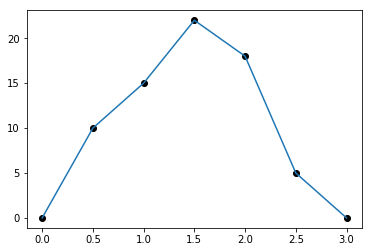

In [46]:
plt.plot(df.t,df.x,'ko')
#plt.plot(df.t,P(df.t),'ro')
plt.plot(df.t,P(df.t) )

In [47]:
S(P(df.t))

8.1999999999957627

We can now have an smoth fit

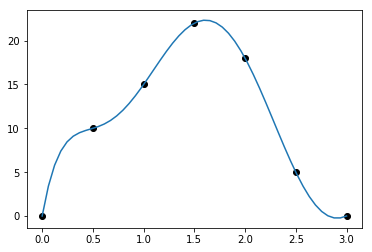

In [53]:
t=linspace(0,3,50)
plt.plot(df.t,df.x,'ko')
plt.plot(t,P(t) )

In [54]:
S(P(t))

30.092593601127142

### Exercise
Try to find a large action (larger than 10 J$\cdot$s) and the minimal possible action

### The least action

Function to find the least Action by using `scipy.optimize.fmin_powell`. It start from $\mathbf{x}=(x_{\hbox{ini}},0,0,\ldots,x_{\hbox{end}})$ and find the least action

In [5]:
def xfit(n,t=3.,m=0.2,xini=0.,xend=0.,ftol=1E-8):
    '''Find the array of n (odd) components that minimizes the action S(x)

    :Parameters:

    n: odd integer 
        dimension of the ndarray x that minimizes the action  S(x,t,m)
    t,m: numbers
       optional parameters for the action
    ftol: number
        acceptable relative error in S(x) for convergence.

    :Returns: (x,xmax,Smin)
    
    x: ndarray
        minimizer of the action S(x)
        
    xini:
    
    xend:

    xmax: number
        Maximum height for the object

    Smin: number
        value of function at minimum: Smin = S(x)
    '''
    t=float(t)
    if n%2==0:
        print 'x array must be odd'
        sys.exit()
  
    x0=np.zeros(n)
    a=scipy.optimize.fmin_powell(S,x0,args=(t,m,xini,xend),ftol=ftol,full_output=1)
    x=a[0]
    x[0]=xini;x[-1]=xend
    xmax=np.sort(x)[-1]
    Smin=a[1]
    Dt=t/x[:-1].size
    return x,xmax,Smin,Dt  


## Least Action calculation

_Problem_: Let an object of mass $m=0.2$ Kg throw vertically updward and returning back to the same hand after 3 s. Find the function of distance versus time of least Action. 

Let us divide the intervals in 21 parts:

In [6]:
t=3.
m=0.2
y=xfit(21,t,m)
x=y[0]
Smin=y[2]
Dt=t/x[:-1].size
tx=np.arange(0,t+Dt,Dt)

Optimization terminated successfully.
         Current function value: -21.554977
         Iterations: 28
         Function evaluations: 5837


### Plot

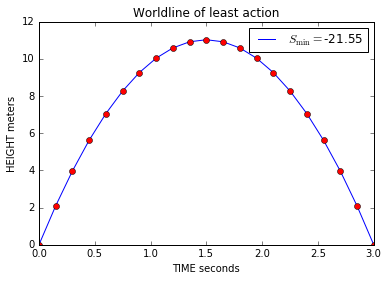

In [9]:
plt.plot(tx,x,label='$S_{\mathrm{min}}=$%.2f' %Smin)
plt.plot(tx,x,'ro')
plt.ylabel('HEIGHT meters')
plt.xlabel('TIME seconds')
plt.title('Worldline of least action')
plt.legend(loc='best')

### Dynamics of the least action solution

#### Velocity

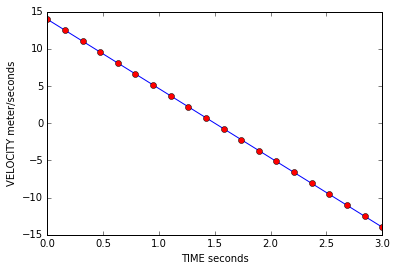

In [10]:
v=(x[1:]-x[:-1])/Dt
Dt=t/v[:-1].size
tx=np.arange(0,t+Dt,Dt)
plt.plot(tx,v)
plt.plot(tx,v,'ro')
plt.xlabel('TIME seconds')
plt.ylabel('VELOCITY meter/seconds')

#### Aceleration

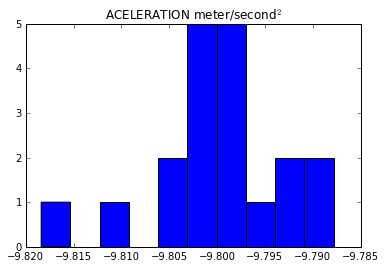

In [11]:
Dt=t/x[:-1].size
a=(v[1:]-v[:-1])/Dt
pa=plt.hist(a)
plt.title('ACELERATION meter/second$^2$')

#### Energy

In [12]:
T=0.5*m*v**2
V=0.5*m*g*(x[1:]+x[:-1])
E=T+V
print np.round(E,2)

[ 21.56  21.56  21.56  21.56  21.56  21.56  21.55  21.55  21.56  21.56
  21.56  21.56  21.56  21.56  21.56  21.55  21.55  21.56  21.56  21.55]


#### Action

The Action is minimal in each interval!

In [13]:
SS=(T-V)*Dt
SS

array([ 2.6176807 ,  1.45086655,  0.41339493, -0.49445999, -1.27239049,
       -1.92031545, -2.4394347 , -2.82826668, -3.08743238, -3.21713111,
       -3.21711685, -3.08747346, -2.82816485, -2.43888968, -1.9203943 ,
       -1.27224487, -0.49433121,  0.41338257,  1.45064061,  2.61710336])

In [14]:
print 'S_MINIMUM=%g  Joules*second' %SS.sum()

S_MINIMUM=-21.555  Joules*second
